# Lab 3 - Prior and Posterior predictive distributions

Dawid Bogon

The goal of this excercise is to create a binomial model, use prior predictive distributions to select a proper prior and then using posterior predictive distributions.

We will be considering a following case:

Typical effects of administering certain vaccine result in an allergic reaction in 20% cases on average. This is what we know a priori

We are testing a new vaccine, for which we performed a trial on 50 patients registering 7 allergic reactions. We want to verify what is the allergic reaction probability for new trial and what is the probability that it is lower than for normal vacine. We assume that each patient treatment is exchangeable.

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Modeling prior predictive distribution

Because prior predictive distribution does not use data it can often be realized just using random number generators. 

1. Create a Stan model, which will consist of only ```generated quantites``` block.
2. In this block define integer variable ```N``` for number of trials equal to 50, integer variable ```y``` for number of successes and real ```p``` for probability of allergic reaction. Remember to use necessary constraints.
3. Assign a prior for  ```p``` (appropriate random number generator) that will represent our knowledge about typical cases. You can do it either analytically or by using simulations. 
4. Sample from binomial distribution, that will use ```N``` and sampled ```p``` to generate number of allergic reactions ```y```.
5. Generate 1000 samples (pair of ```p``` an ```y```) by calling appropriate method in ```cmdstanpy```. Remeber to set ```fixed_param=True```.
6. Compute ratio of allergic reactions for each sample and create a histogram.
7. Verify if mean of the ratio is consistent with prior knowledge, otherwise modify prior parameters. Describe your reasoning in the report.

In [2]:
gen_quant = CmdStanModel(stan_file='code_1.stan')
samples = gen_quant.sample(fixed_param=True,
                           iter_sampling=1000,
                           iter_warmup=0, 
                           chains = 1)
df = samples.draws_pd()
df.describe()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,N,y,p
count,1000.0,1000.0,1000.0,1000.00000,1000.000000
mean,0.0,0.0,50.0,10.05000,0.199877
std,0.0,0.0,0.0,3.43967,0.040015
min,0.0,0.0,50.0,2.00000,0.055974
25%,0.0,0.0,50.0,8.00000,0.174169
50%,0.0,0.0,50.0,10.00000,0.201498
75%,0.0,0.0,50.0,12.00000,0.227251
max,0.0,0.0,50.0,22.00000,0.321217


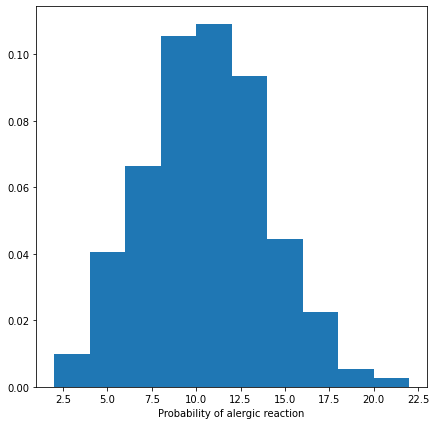

Mean of ratio: 0.20100000000000004


In [3]:
plt.figure(figsize=(7, 7))
plt.hist(df["y"] ,density=True)
plt.gca().set_xlabel("Probability of alergic reaction")
plt.show()

df["y_prob"] = df["y"] / df["N"]
mean = df["y_prob"].mean()
print(f"Mean of ratio: {mean}")

## Modeling posterior and posterior predictive distribution

1. Create a Stan model in which:
   - ```N``` and ```y``` are appropriately defined in the ```data``` block.
   - ```p``` is defined in the parameters block. 
   - binomial likelihood and prior (selected using prior predictive distribution) are defined in the model block.
   - new integer variable ```y_pred``` in the generated quantities block. 
   - sample ```y_pred``` using values of parameter ```p``` and input variable ```N```
2. Generate default number of samples from appropriate method in ```cmdstanpy```.
3. Compute ratio of predicted allergic reactions for each sample and create a histogram.
4. Compute the expected value and 94% density interval of the predicted ratio, compare it with expected value and 94% density interval of parameter ```p```. Use ```arviz``` package.
5. Compute the probability that ratio is lower than the average probability from traditional vaccines (count the number of simulated ratios that are smaller).

In [4]:
gen_quant2 = CmdStanModel(stan_file='code_2.stan')

samples2 = gen_quant2.sample(data={'N':50,'y':10})

df2 = samples2.draws_pd()
df2.describe()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000
mean,-27.356469,0.938137,0.873547,1.445250,2.971500,0.0,27.864908,0.200237,10.034000
std,0.735364,0.092171,0.026568,0.529691,1.760387,0.0,1.015401,0.026323,3.134853
min,-34.777700,0.215734,0.836113,1.000000,1.000000,0.0,26.847900,0.102466,1.000000
25%,-27.530350,0.917317,0.861860,1.000000,1.000000,0.0,27.141775,0.182874,8.000000
50%,-27.073850,0.976085,0.873542,1.000000,3.000000,0.0,27.574700,0.199940,10.000000
75%,-26.896400,0.999201,0.885229,2.000000,3.000000,0.0,28.233975,0.218064,12.000000
max,-26.847800,1.000000,0.910992,3.000000,7.000000,0.0,34.918000,0.296448,22.000000


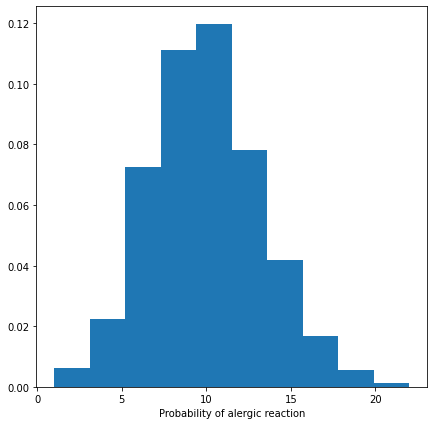

Mean of ratio: 0.20068000000000003


In [5]:
plt.figure(figsize=(7, 7))
plt.hist(df2["y_pred"] ,density=True)
plt.gca().set_xlabel("Probability of alergic reaction")
plt.show()

df2["y_prob"] = df2["y_pred"] / 50
mean = df2["y_prob"].mean()
print(f"Mean of ratio: {mean}")

In [6]:
y_pred_ratio = df2["y_prob"].mean()
y_pred_density_interval = az.hdi(df2["y_prob"].to_numpy(), credible_interval=0.94)

p_ratio = df2["p"].mean()
p_density_interval = az.hdi(df2["p"].to_numpy(), credible_interval=0.94)

ratio_lower_than_avg = np.sum(df2["y_prob"] < 0.2) / len(df2["y_prob"])

print(f"Expected ratio = {y_pred_ratio:.3f}")
print("94% density interval of the predicted ratio = ", y_pred_density_interval)

print(f"Expected value of parameter p = {p_ratio:.3f}")
print("94% density interval of the parameter p = ", p_density_interval)

print(f"Probability that ratio is lower than the average probability = {ratio_lower_than_avg:.3f}")

Expected ratio = 0.201
94% density interval of the predicted ratio =  [0.1  0.32]
Expected value of parameter p = 0.200
94% density interval of the parameter p =  [0.149979 0.24898 ]
Probability that ratio is lower than the average probability = 0.447
